In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input, Dense, Activation, BatchNormalization, \
                                    Flatten, Conv1D, MaxPooling1D, Dropout, \
                                    Concatenate, GlobalMaxPool1D, GlobalAvgPool1D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_cnn(conv_num=1):
    filter_size = 32

    input_layer = Input(shape=input_shape)
    x = input_layer

    layer_outputs = []
    for i in range(conv_num):
        x = Conv1D (kernel_size=5, filters=filter_size*(2**(i//4)), 
                          strides=1, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = MaxPooling1D(pool_size=3, strides=3)(x)
        layer_outputs.append(x)    
    
    x = Concatenate()([GlobalAvgPool1D()(output) for output in layer_outputs[-2:]])
    x = BatchNormalization()(x)
    x = Dense(output_size, activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=x)
    return model

In [9]:
for i in range(3, 9):
    model = build_cnn(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 16000, 32)    192         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 16000, 32)    128         conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 16000, 32)    0           batch_normalization_v1[0][0]     
_____________________________________

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 16000, 32)    192         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_9 (Batch (None, 16000, 32)    128         conv1d_7[0][0]                   
__________________________________________________________________________________________________
activation_7 (Activation)       (None, 16000, 32)    0           batch_normalization_v1_9[0][0]   
__________________________________________________________________________________________________
max_poolin

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_18 (Conv1D)              (None, 16000, 32)    192         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_22 (Batc (None, 16000, 32)    128         conv1d_18[0][0]                  
__________________________________________________________________________________________________
activation_18 (Activation)      (None, 16000, 32)    0           batch_normalization_v1_22[0][0]  
__________________________________________________________________________________________________
max_poolin

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36736/36805 [============================>.] - ETA: 0s - loss: 2.2345 - acc: 0.3168
Epoch 00001: val_loss improved from inf to 2.26297, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_BN_3_conv_checkpoint/001-2.2630.hdf5
36805/36805 [==============================] - 32s 863us/sample - loss: 2.2338 - acc: 0.3170 - val_loss: 2.2630 - val_acc: 0.2662
Epoch 2/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.7634 - acc: 0.4633
Epoch 00002: val_loss improved from 2.26297 to 1.76292, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_BN_3_conv_checkpoint/002-1.7629.hdf5
36805/36805 [==============================] - 28s 772us/sample - loss: 1.7630 - acc: 0.4634 - val_loss: 1.7629 - val_acc: 0.4472
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5765 - acc: 0.5267
Epoch 00003: val_loss improved from 1.76292

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9317 - acc: 0.7276
Epoch 00027: val_loss did not improve from 1.23986
36805/36805 [==============================] - 28s 755us/sample - loss: 0.9318 - acc: 0.7275 - val_loss: 1.5456 - val_acc: 0.5129
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9208 - acc: 0.7293
Epoch 00028: val_loss improved from 1.23986 to 1.18721, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_BN_3_conv_checkpoint/028-1.1872.hdf5
36805/36805 [==============================] - 28s 759us/sample - loss: 0.9209 - acc: 0.7293 - val_loss: 1.1872 - val_acc: 0.6261
Epoch 29/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.9158 - acc: 0.7325
Epoch 00029: val_loss improved from 1.18721 to 1.18175, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_BN_3_conv_checkpoint/029-1.1818.hdf5
36805/36805 [==============================] - 28s 770us/sample - loss: 0.9154 - a

Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8065 - acc: 0.7654
Epoch 00055: val_loss did not improve from 0.94246
36805/36805 [==============================] - 28s 749us/sample - loss: 0.8065 - acc: 0.7653 - val_loss: 0.9619 - val_acc: 0.7058
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7997 - acc: 0.7656
Epoch 00056: val_loss improved from 0.94246 to 0.85816, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_BN_3_conv_checkpoint/056-0.8582.hdf5
36805/36805 [==============================] - 28s 755us/sample - loss: 0.7997 - acc: 0.7656 - val_loss: 0.8582 - val_acc: 0.7519
Epoch 57/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.7955 - acc: 0.7682
Epoch 00057: val_loss did not improve from 0.85816
36805/36805 [==============================] - 28s 765us/sample - loss: 0.7959 - acc: 0.7681 - val_loss: 1.4942 - val_acc: 0.5705
Epoch 58/500
36800/36805 [============================>.] -

36800/36805 [============================>.] - ETA: 0s - loss: 0.7304 - acc: 0.7869
Epoch 00084: val_loss did not improve from 0.85816
36805/36805 [==============================] - 28s 765us/sample - loss: 0.7305 - acc: 0.7869 - val_loss: 1.1798 - val_acc: 0.6401
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7302 - acc: 0.7854
Epoch 00085: val_loss did not improve from 0.85816
36805/36805 [==============================] - 28s 767us/sample - loss: 0.7303 - acc: 0.7854 - val_loss: 1.0718 - val_acc: 0.6834
Epoch 86/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.7241 - acc: 0.7860
Epoch 00086: val_loss did not improve from 0.85816
36805/36805 [==============================] - 28s 766us/sample - loss: 0.7239 - acc: 0.7861 - val_loss: 1.5648 - val_acc: 0.5851
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7233 - acc: 0.7888
Epoch 00087: val_loss did not improve from 0.85816
36805/36805 [==================

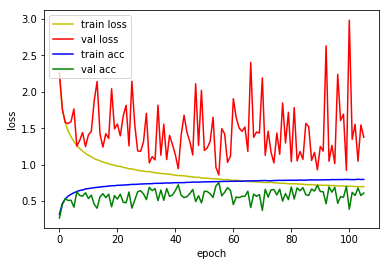

4815/4815 [==============================] - 2s 367us/sample - loss: 0.9155 - acc: 0.7254
Loss: 0.9154667171238615 Accuracy: 0.72544134

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0467 - acc: 0.3704
Epoch 00001: val_loss improved from inf to 2.04292, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_BN_4_conv_checkpoint/001-2.0429.hdf5
36805/36805 [==============================] - 33s 901us/sample - loss: 2.0467 - acc: 0.3704 - val_loss: 2.0429 - val_acc: 0.3245
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5724 - acc: 0.5298
Epoch 00002: val_loss improved from 2.04292 to 1.45724, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_BN_4_conv_checkpoint/002-1.4572.hdf5
36805/36805 [==============================] - 29s 794us/sample - loss: 1.5723 - acc: 0.5298 - val_loss: 1.4572 - val_acc: 0.5730
Epoch 3/500
36800/36805 [=========================

36800/36805 [============================>.] - ETA: 0s - loss: 0.7592 - acc: 0.7790
Epoch 00025: val_loss did not improve from 0.80889
36805/36805 [==============================] - 29s 789us/sample - loss: 0.7593 - acc: 0.7790 - val_loss: 0.8338 - val_acc: 0.7431
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7559 - acc: 0.7807
Epoch 00026: val_loss did not improve from 0.80889
36805/36805 [==============================] - 29s 789us/sample - loss: 0.7559 - acc: 0.7806 - val_loss: 0.8311 - val_acc: 0.7666
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7446 - acc: 0.7833
Epoch 00027: val_loss did not improve from 0.80889
36805/36805 [==============================] - 29s 794us/sample - loss: 0.7447 - acc: 0.7833 - val_loss: 0.9670 - val_acc: 0.7060
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7396 - acc: 0.7843
Epoch 00028: val_loss did not improve from 0.80889
36805/36805 [==================

Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6064 - acc: 0.8235
Epoch 00054: val_loss did not improve from 0.65161
36805/36805 [==============================] - 29s 785us/sample - loss: 0.6064 - acc: 0.8235 - val_loss: 0.7067 - val_acc: 0.8134
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6032 - acc: 0.8262
Epoch 00055: val_loss did not improve from 0.65161
36805/36805 [==============================] - 29s 786us/sample - loss: 0.6035 - acc: 0.8262 - val_loss: 0.8355 - val_acc: 0.7324
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5998 - acc: 0.8243
Epoch 00056: val_loss did not improve from 0.65161
36805/36805 [==============================] - 29s 790us/sample - loss: 0.6000 - acc: 0.8243 - val_loss: 0.8360 - val_acc: 0.7412
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5949 - acc: 0.8278
Epoch 00057: val_loss did not improve from 0.65161
36805/36805 [=====

Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5261 - acc: 0.8485
Epoch 00083: val_loss did not improve from 0.59022
36805/36805 [==============================] - 29s 784us/sample - loss: 0.5261 - acc: 0.8486 - val_loss: 0.7103 - val_acc: 0.7945
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5243 - acc: 0.8482
Epoch 00084: val_loss did not improve from 0.59022
36805/36805 [==============================] - 29s 791us/sample - loss: 0.5243 - acc: 0.8482 - val_loss: 0.6974 - val_acc: 0.8050
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5183 - acc: 0.8505
Epoch 00085: val_loss did not improve from 0.59022
36805/36805 [==============================] - 29s 785us/sample - loss: 0.5182 - acc: 0.8505 - val_loss: 0.7902 - val_acc: 0.7750
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5188 - acc: 0.8479
Epoch 00086: val_loss did not improve from 0.59022
36805/36805 [=====

Epoch 112/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4712 - acc: 0.8623
Epoch 00112: val_loss did not improve from 0.57696
36805/36805 [==============================] - 29s 791us/sample - loss: 0.4713 - acc: 0.8623 - val_loss: 0.6259 - val_acc: 0.8225
Epoch 113/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4676 - acc: 0.8633
Epoch 00113: val_loss did not improve from 0.57696
36805/36805 [==============================] - 29s 786us/sample - loss: 0.4679 - acc: 0.8632 - val_loss: 0.7813 - val_acc: 0.7736
Epoch 114/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4641 - acc: 0.8643
Epoch 00114: val_loss did not improve from 0.57696
36805/36805 [==============================] - 29s 788us/sample - loss: 0.4641 - acc: 0.8643 - val_loss: 0.6637 - val_acc: 0.8167
Epoch 115/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4659 - acc: 0.8642
Epoch 00115: val_loss did not improve from 0.57696
36805/36805 [=

Epoch 141/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4225 - acc: 0.8774
Epoch 00141: val_loss did not improve from 0.56038
36805/36805 [==============================] - 29s 790us/sample - loss: 0.4225 - acc: 0.8774 - val_loss: 0.6819 - val_acc: 0.8006
Epoch 142/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4255 - acc: 0.8766
Epoch 00142: val_loss improved from 0.56038 to 0.55971, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_BN_4_conv_checkpoint/142-0.5597.hdf5
36805/36805 [==============================] - 29s 788us/sample - loss: 0.4256 - acc: 0.8766 - val_loss: 0.5597 - val_acc: 0.8498
Epoch 143/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4241 - acc: 0.8773
Epoch 00143: val_loss did not improve from 0.55971
36805/36805 [==============================] - 29s 788us/sample - loss: 0.4240 - acc: 0.8773 - val_loss: 0.7753 - val_acc: 0.7757
Epoch 144/500
36800/36805 [============================>

Epoch 170/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3936 - acc: 0.8852
Epoch 00170: val_loss did not improve from 0.55971
36805/36805 [==============================] - 29s 788us/sample - loss: 0.3936 - acc: 0.8853 - val_loss: 0.6040 - val_acc: 0.8311
Epoch 171/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3878 - acc: 0.8856
Epoch 00171: val_loss did not improve from 0.55971
36805/36805 [==============================] - 29s 789us/sample - loss: 0.3878 - acc: 0.8856 - val_loss: 0.7103 - val_acc: 0.8134
Epoch 172/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3891 - acc: 0.8860
Epoch 00172: val_loss improved from 0.55971 to 0.53670, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_BN_4_conv_checkpoint/172-0.5367.hdf5
36805/36805 [==============================] - 29s 791us/sample - loss: 0.3892 - acc: 0.8859 - val_loss: 0.5367 - val_acc: 0.8519
Epoch 173/500
36800/36805 [============================>

Epoch 199/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3624 - acc: 0.8929
Epoch 00199: val_loss did not improve from 0.53670
36805/36805 [==============================] - 29s 788us/sample - loss: 0.3625 - acc: 0.8929 - val_loss: 1.1717 - val_acc: 0.7030
Epoch 200/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3614 - acc: 0.8950
Epoch 00200: val_loss did not improve from 0.53670
36805/36805 [==============================] - 29s 787us/sample - loss: 0.3614 - acc: 0.8950 - val_loss: 0.6535 - val_acc: 0.8209
Epoch 201/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3602 - acc: 0.8958
Epoch 00201: val_loss did not improve from 0.53670
36805/36805 [==============================] - 29s 789us/sample - loss: 0.3605 - acc: 0.8957 - val_loss: 0.6651 - val_acc: 0.8130
Epoch 202/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3608 - acc: 0.8941
Epoch 00202: val_loss did not improve from 0.53670
36805/36805 [=

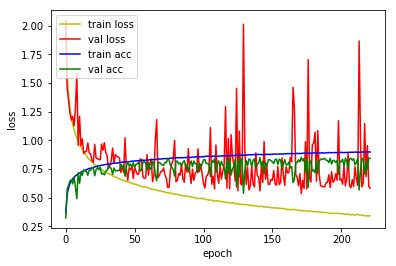

4815/4815 [==============================] - 2s 397us/sample - loss: 0.6321 - acc: 0.8216
Loss: 0.6321213007097056 Accuracy: 0.8215992

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9732 - acc: 0.3945
Epoch 00001: val_loss improved from inf to 1.97618, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_BN_5_conv_checkpoint/001-1.9762.hdf5
36805/36805 [==============================] - 38s 1ms/sample - loss: 1.9731 - acc: 0.3945 - val_loss: 1.9762 - val_acc: 0.3235
Epoch 2/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.3951 - acc: 0.5886
Epoch 00002: val_loss improved from 1.97618 to 1.31451, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_BN_5_conv_checkpoint/002-1.3145.hdf5
36805/36805 [==============================] - 31s 841us/sample - loss: 1.3952 - acc: 0.5887 - val_loss: 1.3145 - val_acc: 0.6082
Epoch 3/500
36800/36805 [============================

Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4366 - acc: 0.8793
Epoch 00024: val_loss did not improve from 0.46063
36805/36805 [==============================] - 31s 841us/sample - loss: 0.4367 - acc: 0.8793 - val_loss: 0.5105 - val_acc: 0.8623
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4229 - acc: 0.8844
Epoch 00025: val_loss did not improve from 0.46063
36805/36805 [==============================] - 31s 837us/sample - loss: 0.4230 - acc: 0.8843 - val_loss: 0.5984 - val_acc: 0.8199
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4127 - acc: 0.8856
Epoch 00026: val_loss did not improve from 0.46063
36805/36805 [==============================] - 31s 837us/sample - loss: 0.4127 - acc: 0.8856 - val_loss: 0.4856 - val_acc: 0.8717
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4058 - acc: 0.8872
Epoch 00027: val_loss did not improve from 0.46063
36805/36805 [=====

36800/36805 [============================>.] - ETA: 0s - loss: 0.2748 - acc: 0.9219
Epoch 00051: val_loss did not improve from 0.38486
36805/36805 [==============================] - 31s 829us/sample - loss: 0.2748 - acc: 0.9219 - val_loss: 0.4662 - val_acc: 0.8647
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2726 - acc: 0.9212
Epoch 00052: val_loss did not improve from 0.38486
36805/36805 [==============================] - 31s 836us/sample - loss: 0.2726 - acc: 0.9212 - val_loss: 0.4845 - val_acc: 0.8633
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2670 - acc: 0.9243
Epoch 00053: val_loss did not improve from 0.38486
36805/36805 [==============================] - 31s 839us/sample - loss: 0.2670 - acc: 0.9243 - val_loss: 0.4049 - val_acc: 0.8940
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2616 - acc: 0.9252
Epoch 00054: val_loss did not improve from 0.38486
36805/36805 [==================

Epoch 80/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1962 - acc: 0.9435
Epoch 00080: val_loss did not improve from 0.34330
36805/36805 [==============================] - 31s 831us/sample - loss: 0.1961 - acc: 0.9435 - val_loss: 0.4036 - val_acc: 0.8945
Epoch 81/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.1930 - acc: 0.9446
Epoch 00081: val_loss did not improve from 0.34330
36805/36805 [==============================] - 31s 837us/sample - loss: 0.1929 - acc: 0.9447 - val_loss: 0.3565 - val_acc: 0.9024
Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1902 - acc: 0.9451
Epoch 00082: val_loss did not improve from 0.34330
36805/36805 [==============================] - 31s 832us/sample - loss: 0.1904 - acc: 0.9450 - val_loss: 0.3654 - val_acc: 0.9038
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1906 - acc: 0.9460
Epoch 00083: val_loss did not improve from 0.34330
36805/36805 [=====

36800/36805 [============================>.] - ETA: 0s - loss: 0.1447 - acc: 0.9573
Epoch 00109: val_loss did not improve from 0.33942
36805/36805 [==============================] - 31s 835us/sample - loss: 0.1448 - acc: 0.9572 - val_loss: 0.5460 - val_acc: 0.8544
Epoch 110/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.1439 - acc: 0.9570
Epoch 00110: val_loss did not improve from 0.33942
36805/36805 [==============================] - 31s 831us/sample - loss: 0.1439 - acc: 0.9571 - val_loss: 0.4234 - val_acc: 0.8945
Epoch 111/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.1469 - acc: 0.9575
Epoch 00111: val_loss did not improve from 0.33942
36805/36805 [==============================] - 31s 835us/sample - loss: 0.1469 - acc: 0.9575 - val_loss: 0.4099 - val_acc: 0.8952
Epoch 112/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.1397 - acc: 0.9603
Epoch 00112: val_loss did not improve from 0.33942
36805/36805 [===============

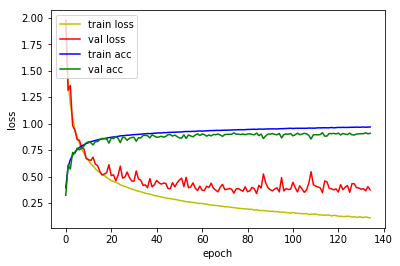

4815/4815 [==============================] - 2s 450us/sample - loss: 0.4086 - acc: 0.8837
Loss: 0.408611616414903 Accuracy: 0.8836968

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7259 - acc: 0.4746
Epoch 00001: val_loss improved from inf to 1.59963, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_BN_6_conv_checkpoint/001-1.5996.hdf5
36805/36805 [==============================] - 43s 1ms/sample - loss: 1.7258 - acc: 0.4746 - val_loss: 1.5996 - val_acc: 0.5127
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0789 - acc: 0.6960
Epoch 00002: val_loss improved from 1.59963 to 0.92916, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_BN_6_conv_checkpoint/002-0.9292.hdf5
36805/36805 [==============================] - 33s 888us/sample - loss: 1.0788 - acc: 0.6960 - val_loss: 0.9292 - val_acc: 0.7421
Epoch 3/500
36800/36805 [============================>

36800/36805 [============================>.] - ETA: 0s - loss: 0.2050 - acc: 0.9428
Epoch 00024: val_loss improved from 0.26356 to 0.26205, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_BN_6_conv_checkpoint/024-0.2621.hdf5
36805/36805 [==============================] - 33s 890us/sample - loss: 0.2050 - acc: 0.9428 - val_loss: 0.2621 - val_acc: 0.9269
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1992 - acc: 0.9424
Epoch 00025: val_loss improved from 0.26205 to 0.25660, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_BN_6_conv_checkpoint/025-0.2566.hdf5
36805/36805 [==============================] - 32s 883us/sample - loss: 0.1992 - acc: 0.9424 - val_loss: 0.2566 - val_acc: 0.9273
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1918 - acc: 0.9454
Epoch 00026: val_loss did not improve from 0.25660
36805/36805 [==============================] - 32s 881us/sample - loss: 0.1918 - acc: 0.9454 - 

Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0927 - acc: 0.9752
Epoch 00051: val_loss did not improve from 0.22109
36805/36805 [==============================] - 33s 884us/sample - loss: 0.0927 - acc: 0.9752 - val_loss: 0.2652 - val_acc: 0.9266
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0922 - acc: 0.9737
Epoch 00052: val_loss did not improve from 0.22109
36805/36805 [==============================] - 32s 880us/sample - loss: 0.0923 - acc: 0.9737 - val_loss: 0.2846 - val_acc: 0.9210
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0904 - acc: 0.9751
Epoch 00053: val_loss did not improve from 0.22109
36805/36805 [==============================] - 32s 882us/sample - loss: 0.0906 - acc: 0.9750 - val_loss: 0.2469 - val_acc: 0.9283
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0878 - acc: 0.9751
Epoch 00054: val_loss did not improve from 0.22109
36805/36805 [=====

Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0473 - acc: 0.9878
Epoch 00081: val_loss did not improve from 0.22109
36805/36805 [==============================] - 32s 869us/sample - loss: 0.0475 - acc: 0.9878 - val_loss: 0.2581 - val_acc: 0.9341
Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0476 - acc: 0.9881
Epoch 00082: val_loss did not improve from 0.22109
36805/36805 [==============================] - 32s 868us/sample - loss: 0.0476 - acc: 0.9881 - val_loss: 0.2693 - val_acc: 0.9329
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0438 - acc: 0.9886
Epoch 00083: val_loss did not improve from 0.22109
36805/36805 [==============================] - 32s 868us/sample - loss: 0.0438 - acc: 0.9886 - val_loss: 0.2518 - val_acc: 0.9359
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0422 - acc: 0.9887
Epoch 00084: val_loss did not improve from 0.22109
36805/36805 [=====

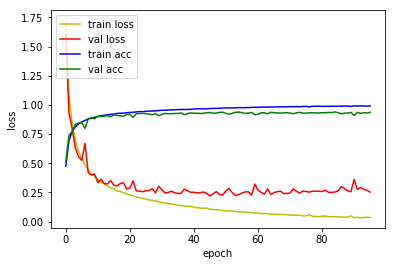

4815/4815 [==============================] - 2s 458us/sample - loss: 0.2878 - acc: 0.9182
Loss: 0.2878276407471079 Accuracy: 0.91817236

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6040 - acc: 0.5142
Epoch 00001: val_loss improved from inf to 1.67429, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_BN_7_conv_checkpoint/001-1.6743.hdf5
36805/36805 [==============================] - 47s 1ms/sample - loss: 1.6040 - acc: 0.5142 - val_loss: 1.6743 - val_acc: 0.4472
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8270 - acc: 0.7674
Epoch 00002: val_loss improved from 1.67429 to 0.65864, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_BN_7_conv_checkpoint/002-0.6586.hdf5
36805/36805 [==============================] - 34s 919us/sample - loss: 0.8271 - acc: 0.7674 - val_loss: 0.6586 - val_acc: 0.8204
Epoch 3/500
36800/36805 [===========================

Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1099 - acc: 0.9683
Epoch 00024: val_loss did not improve from 0.17117
36805/36805 [==============================] - 34s 918us/sample - loss: 0.1099 - acc: 0.9683 - val_loss: 0.1991 - val_acc: 0.9373
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0947 - acc: 0.9743
Epoch 00025: val_loss did not improve from 0.17117
36805/36805 [==============================] - 34s 914us/sample - loss: 0.0949 - acc: 0.9743 - val_loss: 0.1729 - val_acc: 0.9502
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0924 - acc: 0.9742
Epoch 00026: val_loss did not improve from 0.17117
36805/36805 [==============================] - 33s 910us/sample - loss: 0.0925 - acc: 0.9742 - val_loss: 0.2066 - val_acc: 0.9413
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0901 - acc: 0.9747
Epoch 00027: val_loss did not improve from 0.17117
36805/36805 [=====

Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0264 - acc: 0.9938
Epoch 00054: val_loss did not improve from 0.17117
36805/36805 [==============================] - 33s 907us/sample - loss: 0.0265 - acc: 0.9938 - val_loss: 0.1999 - val_acc: 0.9471
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0264 - acc: 0.9940
Epoch 00055: val_loss did not improve from 0.17117
36805/36805 [==============================] - 33s 907us/sample - loss: 0.0264 - acc: 0.9940 - val_loss: 0.1885 - val_acc: 0.9499
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0213 - acc: 0.9958
Epoch 00056: val_loss did not improve from 0.17117
36805/36805 [==============================] - 34s 912us/sample - loss: 0.0213 - acc: 0.9958 - val_loss: 0.2092 - val_acc: 0.9462
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0198 - acc: 0.9963
Epoch 00057: val_loss did not improve from 0.17117
36805/36805 [=====

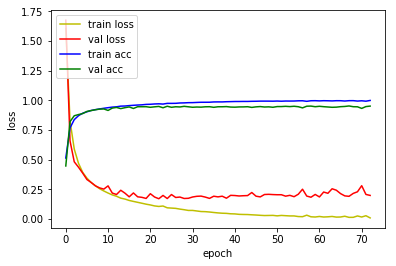

4815/4815 [==============================] - 2s 519us/sample - loss: 0.2410 - acc: 0.9248
Loss: 0.24100409129698327 Accuracy: 0.9248183

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5845 - acc: 0.5216
Epoch 00001: val_loss improved from inf to 1.35203, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_BN_8_conv_checkpoint/001-1.3520.hdf5
36805/36805 [==============================] - 54s 1ms/sample - loss: 1.5844 - acc: 0.5217 - val_loss: 1.3520 - val_acc: 0.5966
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7422 - acc: 0.7881
Epoch 00002: val_loss improved from 1.35203 to 0.68749, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_BN_8_conv_checkpoint/002-0.6875.hdf5
36805/36805 [==============================] - 35s 950us/sample - loss: 0.7424 - acc: 0.7880 - val_loss: 0.6875 - val_acc: 0.7876
Epoch 3/500
36800/36805 [===========================

Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0648 - acc: 0.9828
Epoch 00025: val_loss did not improve from 0.18148
36805/36805 [==============================] - 35s 949us/sample - loss: 0.0648 - acc: 0.9828 - val_loss: 0.1961 - val_acc: 0.9373
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0562 - acc: 0.9858
Epoch 00026: val_loss improved from 0.18148 to 0.17459, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_32_BN_8_conv_checkpoint/026-0.1746.hdf5
36805/36805 [==============================] - 35s 956us/sample - loss: 0.0562 - acc: 0.9858 - val_loss: 0.1746 - val_acc: 0.9443
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0515 - acc: 0.9875
Epoch 00027: val_loss did not improve from 0.17459
36805/36805 [==============================] - 35s 946us/sample - loss: 0.0515 - acc: 0.9875 - val_loss: 0.2332 - val_acc: 0.9297
Epoch 28/500
36800/36805 [============================>.] -

36800/36805 [============================>.] - ETA: 0s - loss: 0.0127 - acc: 0.9974
Epoch 00054: val_loss did not improve from 0.17459
36805/36805 [==============================] - 35s 940us/sample - loss: 0.0127 - acc: 0.9974 - val_loss: 0.2021 - val_acc: 0.9490
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0123 - acc: 0.9978
Epoch 00055: val_loss did not improve from 0.17459
36805/36805 [==============================] - 34s 933us/sample - loss: 0.0123 - acc: 0.9978 - val_loss: 0.2028 - val_acc: 0.9499
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0137 - acc: 0.9969
Epoch 00056: val_loss did not improve from 0.17459
36805/36805 [==============================] - 34s 935us/sample - loss: 0.0137 - acc: 0.9969 - val_loss: 0.2117 - val_acc: 0.9460
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0133 - acc: 0.9974
Epoch 00057: val_loss did not improve from 0.17459
36805/36805 [==================

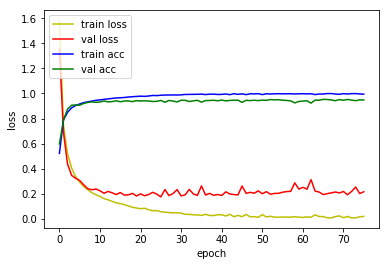

4815/4815 [==============================] - 2s 519us/sample - loss: 0.2577 - acc: 0.9281
Loss: 0.2576975212042701 Accuracy: 0.92814124



In [10]:
base = '1D_CNN_custom_multi_2_GAP_ch_32_BN'

for i in range(3, 9):
    model_name = base+'_{}_conv'.format(i)
    model = build_cnn(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_multi_2_GAP_ch_32_BN'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(3, 9):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_multi_2_GAP_ch_32_BN_3_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_33 (Conv1D)              (None, 16000, 32)    192         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_39 (Batc (None, 16000, 32)    128         conv1d_33[0][0]                  
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16000, 32)    0           batch_normalization_v1_39[0][0]  
____________________________________________________________

4815/4815 [==============================] - 3s 545us/sample - loss: 0.6321 - acc: 0.8216
Loss: 0.6321213007097056 Accuracy: 0.8215992

1D_CNN_custom_multi_2_GAP_ch_32_BN_5_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_40 (Conv1D)              (None, 16000, 32)    192         input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_48 (Batc (None, 16000, 32)    128         conv1d_40[0][0]                  
__________________________________________________________________________________________________
activation_40 (Activatio

4815/4815 [==============================] - 3s 575us/sample - loss: 0.2878 - acc: 0.9182
Loss: 0.2878276407471079 Accuracy: 0.91817236

1D_CNN_custom_multi_2_GAP_ch_32_BN_7_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_51 (Conv1D)              (None, 16000, 32)    192         input_11[0][0]                   
__________________________________________________________________________________________________
batch_normalization_v1_61 (Batc (None, 16000, 32)    128         conv1d_51[0][0]                  
__________________________________________________________________________________________________
activation_51 (Activati

4815/4815 [==============================] - 3s 630us/sample - loss: 0.2577 - acc: 0.9281
Loss: 0.2576975212042701 Accuracy: 0.92814124


In [12]:
for i in range(3, 9):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)


1D_CNN_custom_multi_2_GAP_ch_32_BN_3_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_33 (Conv1D)              (None, 16000, 32)    192         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_39 (Batc (None, 16000, 32)    128         conv1d_33[0][0]                  
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16000, 32)    0           batch_normalization_v1_39[0][0]  
____________________________________________________________

4815/4815 [==============================] - 3s 626us/sample - loss: 0.6571 - acc: 0.8085
Loss: 0.6571419659928494 Accuracy: 0.8085151

1D_CNN_custom_multi_2_GAP_ch_32_BN_5_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_40 (Conv1D)              (None, 16000, 32)    192         input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_48 (Batc (None, 16000, 32)    128         conv1d_40[0][0]                  
__________________________________________________________________________________________________
activation_40 (Activatio

4815/4815 [==============================] - 3s 669us/sample - loss: 0.3010 - acc: 0.9232
Loss: 0.3010020256661428 Accuracy: 0.9231568

1D_CNN_custom_multi_2_GAP_ch_32_BN_7_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_51 (Conv1D)              (None, 16000, 32)    192         input_11[0][0]                   
__________________________________________________________________________________________________
batch_normalization_v1_61 (Batc (None, 16000, 32)    128         conv1d_51[0][0]                  
__________________________________________________________________________________________________
activation_51 (Activatio

4815/4815 [==============================] - 3s 711us/sample - loss: 0.3027 - acc: 0.9331
Loss: 0.30269156234379496 Accuracy: 0.9331257
